<a href="https://colab.research.google.com/github/ravishankarramakrishnan/Deep_Learning_Practice/blob/master/Emotion_AI_Part2_Facial_Expression_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Emotional AI - Facial Expression Classification

Goal: To Predict the Facial Expression using CNN's and Residual Blocks (Residual Networks)

Dataset: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

To Predict: Surprise, Anger, Disguist, Sad, Happiness

In [57]:
# Importing the Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.python.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as k

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import PIL
import pickle
from IPython.display import display

print(f"Tensorflow Version: {tf.version.VERSION}")

Tensorflow Version: 2.3.0


In [2]:
# Importing the Data

emotion_df = pd.read_csv("/content/drive/My Drive/Projects/Emotion AI - Facial_Expression Classification/emotion.csv")

# Validate the DataFrame
emotion_df.head().append(emotion_df.tail())

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
24563,3,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564,0,181 177 176 156 178 144 136 132 122 107 131 16...
24565,3,178 174 172 173 181 188 191 194 196 199 200 20...
24566,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
24567,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


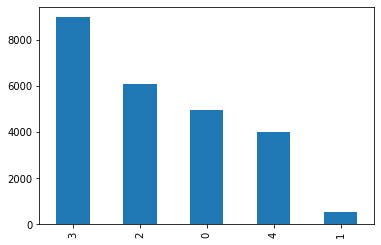

In [3]:
# Get the Distribution of the Emotions

emotion_df['emotion'].value_counts().plot(kind= "bar");

In [4]:
# Encoding of the Data

label_to_text = {0:"anger", 1: "disguist", 2: 'sad', 3: "happiness", 4: "surprise"}

In [5]:
# Check the validity of the Data Type

print(emotion_df[' pixels'][0])
print(emotion_df[' pixels'][0][0])
type(emotion_df[' pixels'][0])

70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92 

str

In [6]:
# Rename the Pixel Column as it has an Extra Space
emotion_df.rename(columns={ emotion_df.columns[1]: "pixels" }, inplace = True)
type(emotion_df['pixels'][0])

str

In [7]:
# Converting from String to Pixels

def string2array(x):
    return np.array(x.split(' ')).reshape(48,48,1).astype('float32')


In [8]:
# Convert String to Array in the Pixel column for the DataFrame

emotion_df['pixels'] = emotion_df['pixels'].apply(lambda x: string2array(x))
print(f"The Shape of the Pixels Column is {emotion_df['pixels'].shape}")
print(f"The Shape of Each Pixels is {emotion_df['pixels'][0].shape}")
type(emotion_df['pixels'][0])

The Shape of the Pixels Column is (24568,)
The Shape of Each Pixels is (48, 48, 1)


numpy.ndarray

In [9]:
# Check the Data for Missing Values

emotion_df.isna().sum()

emotion    0
pixels     0
dtype: int64

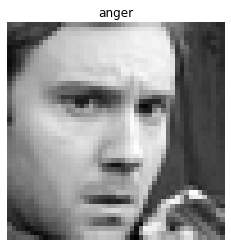

In [10]:
# Plot the First image of the Dataset
plt.imshow(emotion_df['pixels'][0].squeeze(), cmap= "gray") #  squeeze() or Reshape can be used to remove the Last 1 (48,48,1) to (48,48)
plt.title(label_to_text[emotion_df['emotion'][0]])
plt.axis('off');

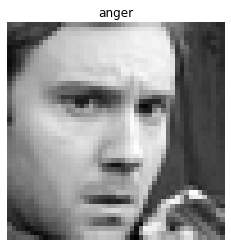

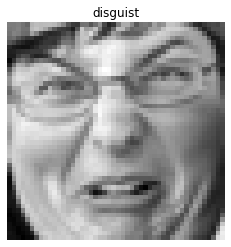

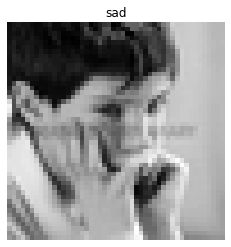

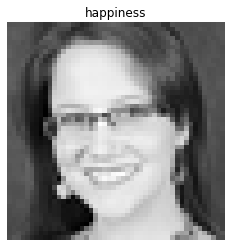

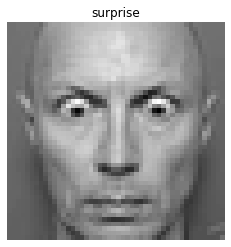

In [11]:
# Performing Data Visualisation - Explore all Emotions

emotions = [0,1,2,3,4]

for i in emotions:
    # Take the Image only
    data = emotion_df[emotion_df['emotion'] == i] [:1]
    img = data['pixels'].item()
    img = img.reshape(48,48)
    plt.figure()
    plt.title(label_to_text[i])
    plt.imshow(img, cmap= "gray")
    plt.axis('off');

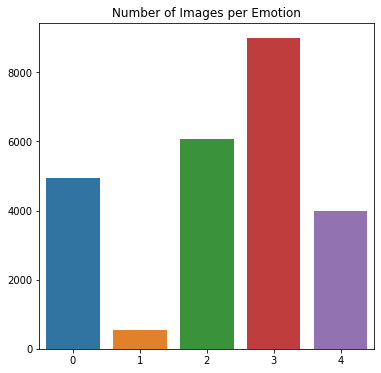

In [12]:
# Plot the Class to identify the Class Imbalance

plt.figure(figsize= (6,6))
sns.barplot(x= emotion_df['emotion'].value_counts().index, y= emotion_df['emotion'].value_counts().values )
plt.title("Number of Images per Emotion");

In [13]:
# As we have Class Imbalance, it might probably Impact the Model. So we perform Image Augmentation (Take Class 1 and add more Variational images)

# Performing Data Augmentation, Normalization and Splitting
X = emotion_df['pixels']
print("The Shape of Image X is ", X.shape)

The Shape of Image X is  (24568,)


In [14]:
# Splitting the DataFrame to Features and Label

# Get the Target Variables - Convert from Numbers to dummies 1 or 0 [Categorical Format]
y = pd.get_dummies(emotion_df['emotion'])

# To convert the 255 images in list in wide format to row format
X = np.stack(X, axis= 0)
X = X.reshape(len(X), 48, 48, 1)

print("The Shapes of X and Y are:", X.shape, y.shape)

The Shapes of X and Y are: (24568, 48, 48, 1) (24568, 5)


In [18]:
# Convert X and y to Arrays
X = np.array(X)
y = np.array(y)

# Split the Data via train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, shuffle= True)

# Create a Validation set from the Test set (Subset with 50/50)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size= 0.5, shuffle= True)

# Validate the Splits

print(f"The Shape of X_train is {X_train.shape} and y_train is {y_train.shape}")
print(f"The Shape of X_test is {X_test.shape} and y_test is {y_test.shape}")
print(f"The Shape of X_val is {X_val.shape} and y_train is {y_val.shape}")

The Shape of X_train is (20882, 48, 48, 1) and y_train is (20882, 5)
The Shape of X_test is (1843, 48, 48, 1) and y_test is (1843, 5)
The Shape of X_val is (1843, 48, 48, 1) and y_train is (1843, 5)


In [19]:
# Preprocessing the Images / Perform Normalisation

X_train = X_train / 255.
X_test = X_test / 255.
X_val = X_val / 255.

In [20]:
# Creating Data Generator - Helps in improving the Generalisation Capability of the Model

train_datagen = ImageDataGenerator(
        rotation_range = 15,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        shear_range = 0.1,
        zoom_range = 0.1,
        fill_mode = "nearest"
)

In [24]:
# As you go through Multiple layers in CNN, Vanishing Gradients problem tends to Occur (Gradient that updates model weight diminishes). 
# So we use ResNet Architecture - Resnets perform better than Humans

# Model Building

# Building Res - Block

def res_block(X, filter, stage):

    # Take a Copy of X in the start to be added in the end, to avoid Vanishing Gradient

    # Convolution Block
    X_copy = X
    f1, f2, f3 = filter

    # Main Path
    X = Conv2D(f1, kernel_size= (1,1), strides= (1,1), name= "res_"+str(stage)+"_conv_a", kernel_initializer = glorot_uniform(seed= 0)) (X)
    X = MaxPool2D((2,2)) (X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_conv_a") (X)
    X = Activation('relu') (X)
    
    
    X = Conv2D(f2, kernel_size= (3,3), strides= (1,1), padding= 'same', name= "res_"+str(stage)+"_conv_b", kernel_initializer = glorot_uniform(seed= 0)) (X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_conv_b") (X)
    X = Activation('relu') (X)

    X = Conv2D(f3, kernel_size= (1,1), strides= (1,1), padding= 'same', name= "res_"+str(stage)+"_conv_c", kernel_initializer = glorot_uniform(seed= 0)) (X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_conv_c") (X)
    
    # Adding Data from Main Short Path
    X_copy = Conv2D(f3, kernel_size= (1,1), strides= (1,1), padding= 'same', name= "res_"+str(stage)+"_conv_copy", kernel_initializer = glorot_uniform(seed= 0)) (X_copy)
    X_copy = MaxPool2D((2,2)) (X_copy)
    X_copy = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_conv_copy") (X_copy)

    # Adding Data from Main and Short Path
    X = Add() ([X, X_copy])
    X = Activation('relu') (X)

    # Identity Block 1
    X_copy = X 

    # Main Path 
    X = Conv2D(f1, kernel_size= (1,1), strides= (1,1), name= "res_"+str(stage)+"_identity_1_a", kernel_initializer= glorot_uniform(seed= 0)) (X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_identity_1_a") (X)
    X = Activation('relu') (X)
    
    X = Conv2D(f2, kernel_size= (3,3), strides= (1,1), padding= "same", name= "res_"+str(stage)+"_identity_1_b", kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_identity_1_b")(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, kernel_size= (1,1), strides= (1,1), name= "res_"+str(stage)+"_identity_1_c", kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_identity_1_c")(X)

    # Add both X Original and Transformed together (We fees Original Input as is. hence the name Identity)
    X = Add() ([X, X_copy])
    X = Activation('relu') (X)


    # Identity Block 2
    X_copy = X

    # Main Path 
    X = Conv2D(f1, kernel_size= (1,1), strides= (1,1), name= "res_"+str(stage)+"_identity_2_a", kernel_initializer= glorot_uniform(seed= 0)) (X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_identity_2_a") (X)
    X = Activation('relu') (X)
    
    X = Conv2D(f2, kernel_size= (3,3), strides= (1,1), padding= "same", name= "res_"+str(stage)+"_identity_2_b", kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_identity_2_b")(X)
    X = Activation('relu')(X)

    X = Conv2D(f3, kernel_size= (1,1), strides= (1,1), name= "res_"+str(stage)+"_identity_2_c", kernel_initializer= glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis= 3, name= "bn_"+str(stage)+"_identity_2_c")(X)

    # Add both X Original and Transformed together (We fees Original Input as is. hence the name Identity)
    X = Add() ([X, X_copy])
    X = Activation('relu') (X)

    return X

In [27]:
# Building the Final Model with for the ResBlock Architecture

input_shape = (48, 48, 1)

# Input Tensor Shape
X_input = Input(input_shape)

# Zero Padding
X = ZeroPadding2D((3,3)) (X_input)

# Stage 1
X = Conv2D(64, (7,7), strides= (2,2), name= "conv1", kernel_initializer = glorot_uniform(seed= 0)) (X)
X = BatchNormalization(axis= 3, name= "bn_conv1") (X)
X = Activation('relu') (X)
X = MaxPool2D((3,3), strides= (2,2)) (X)

# Stage 2
X = res_block(X, filter= [64,64,256], stage= 2)

# Stage 3
X = res_block(X, filter= [128,128,512], stage= 3)

# Stage 4 - Add another ResBlock
# X = res_block(X, filter= [256,256,1024], stage= 4) # Gives InvalidArgumentError

# Average Pooling
X = AveragePooling2D((2,2), name= "Average_Pooling") (X)

# Final Layers
X = Flatten() (X)
X = Dense(4096, activation= "relu") (X)
X = Dropout(0.2) (X)
X = Dense(2048, activation= 'relu') (X)
X = Dropout(0.1) (X)

# Output
X = Dense(5, activation= "softmax", name= "dense_final", kernel_initializer= glorot_uniform(seed= 0)) (X)

# Summarize and Show Model Architecture
model = Model(inputs= X_input, outputs= X, name= "resnet18_classifemotion")
model.summary()

Model: "resnet18_classifemotion"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 54, 54, 1)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 24, 24, 64)   3200        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 24, 24, 64)   256         conv1[0][0]                      
____________________________________________________________________________

In [28]:
# We have 11 Million Trainable Parameters

# Compile and Train the Deep Learning Model

# Optimizer
model.compile(loss= "categorical_crossentropy", metrics= ['accuracy'], optimizer= "Adam")

# Build Early Stopping
earlystopping = EarlyStopping(monitor= "val_loss", patience= 20, verbose= 1, mode='min')

# Save Best Model with least Validation_Loss
filepath = '/content/drive/My Drive/Projects/Emotion AI - Facial_Expression Classification/weights/FacialExpression_weights.hdf5'
checkpoint = ModelCheckpoint(filepath= filepath, monitor="val_loss", verbose= 1, save_best_only= True)

In [29]:
# Train the Model

history = model.fit(train_datagen.flow(X_train, y_train, batch_size= 64),
                    validation_data= (X_val, y_val),
                    steps_per_epoch= len(X_train) // 64,
                    epochs= 100,
                    callbacks= [checkpoint, earlystopping])

Epoch 1/100
325/326 [============================>.] - ETA: 0s - loss: 1.4114 - accuracy: 0.4168
Epoch 00001: val_loss improved from inf to 1.46236, saving model to /content/drive/My Drive/Projects/Emotion AI - Facial_Expression Classification/weights/FacialExpression_weights.hdf5
326/326 [==============================] - 11s 34ms/step - loss: 1.4106 - accuracy: 0.4169 - val_loss: 1.4624 - val_accuracy: 0.3690
Epoch 2/100
326/326 [==============================] - ETA: 0s - loss: 1.1654 - accuracy: 0.5156
Epoch 00002: val_loss improved from 1.46236 to 1.41491, saving model to /content/drive/My Drive/Projects/Emotion AI - Facial_Expression Classification/weights/FacialExpression_weights.hdf5
326/326 [==============================] - 11s 32ms/step - loss: 1.1654 - accuracy: 0.5156 - val_loss: 1.4149 - val_accuracy: 0.4308
Epoch 3/100
325/326 [============================>.] - ETA: 0s - loss: 1.0830 - accuracy: 0.5558
Epoch 00003: val_loss improved from 1.41491 to 1.16906, saving model 

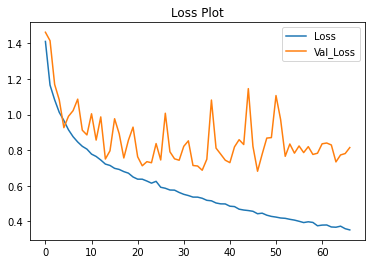

In [33]:
# Plot what's Returned by model.fit()

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['val_loss'], label="Val_Loss")
plt.title("Loss Plot")
plt.legend();

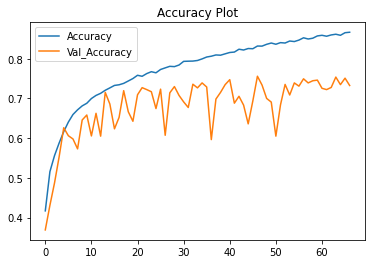

In [34]:
# Plot the Accuracy
plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Val_Accuracy")
plt.title("Accuracy Plot")
plt.legend();

In [31]:
# Save the Model Architecture in JSON Format

model_json = model.to_json()
filename_ = "/content/drive/My Drive/Projects/Emotion AI - Facial_Expression Classification/weights/Emotion_model.json"

with open(filename_, 'w') as json_file:
    json_file.write(model_json)

In [32]:
# Load the Model Architecture

filename_load = "/content/drive/My Drive/Projects/Emotion AI - Facial_Expression Classification/weights/Emotion_model.json"

with open(filename_load, 'r') as json_file:
    json_savedModel = json_file.read()

# Load the Trained Model

model_emotion = tf.keras.models.model_from_json(json_savedModel)
model_emotion.load_weights("/content/drive/My Drive/Projects/Emotion AI - Facial_Expression Classification/weights/FacialExpression_weights.hdf5")

# Optimizer
adam = tf.keras.optimizers.Adam(lr= 0.001, beta_1= 0.9, beta_2= 0.999, amsgrad= False)
model_emotion.compile(loss= "categorical_crossentropy", metrics= ['accuracy'], optimizer= adam)

In [35]:
# Evaluate the Model
result = model_emotion.evaluate(X_test, y_test)
print(f"The Model Accuracy is: {result[1]:.2f} and Loss is: {result[0]:.2f}")

58/58 [==============================] - 0s 6ms/step - loss: 0.6786 - accuracy: 0.7531
The Model Accuracy is: 0.75 and Loss is: 0.68


In [39]:
# Understanding the Model History

print("The Model History is", history.history.keys())
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

The Model History is dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


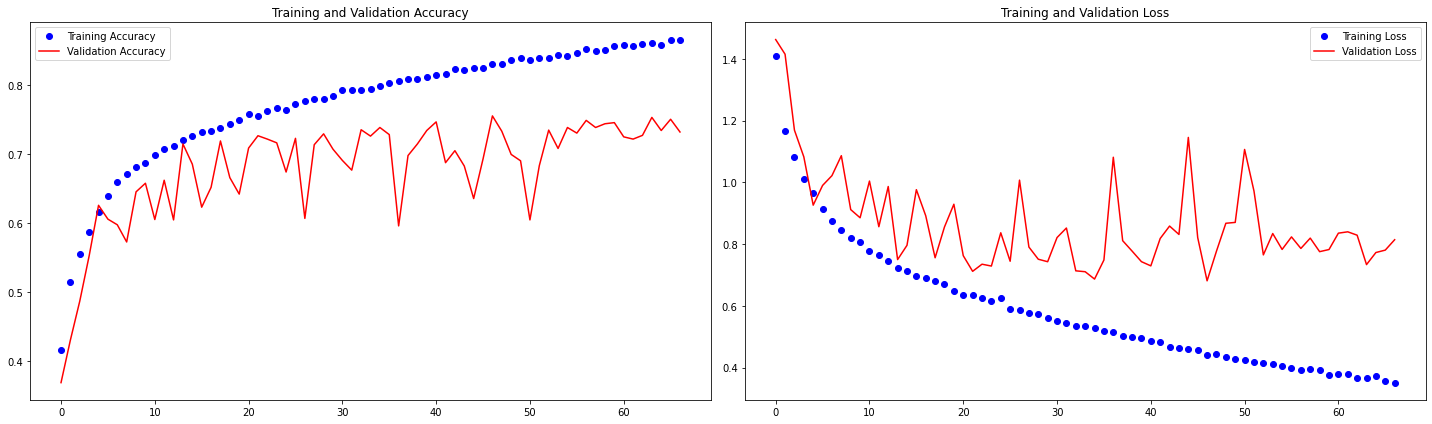

In [48]:
# Plot the Accuracy based on Epochs

epochs = range(len(accuracy))

plt.figure(figsize= (20,6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo', label= "Training Accuracy")
plt.plot(epochs, val_accuracy, 'r-', label= "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label= "Training Loss")
plt.plot(epochs, val_loss, 'r-', label= "Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show();

In [49]:
# Predicting the Test Set

prediction = np.argmax(model_emotion.predict(X_test), axis= -1)
y_true = np.argmax(y_test, axis= -1)

print(f"The Shape of Predictions is {prediction.shape} and y_true shape is {y_true.shape}")

The Shape of Predictions is (1843,) and y_true shape is (1843,)


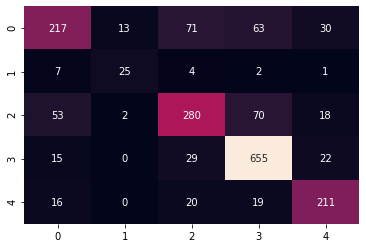



The Classification Report for the Model is:

               precision    recall  f1-score   support

           0       0.70      0.55      0.62       394
           1       0.62      0.64      0.63        39
           2       0.69      0.66      0.68       423
           3       0.81      0.91      0.86       721
           4       0.75      0.79      0.77       266

    accuracy                           0.75      1843
   macro avg       0.72      0.71      0.71      1843
weighted avg       0.75      0.75      0.75      1843



In [60]:
# Validate via Confusion Matrix

cm = confusion_matrix(y_true, prediction)
# Plot the Confusion Matrix
sns.heatmap(cm, annot= True, fmt= "0.0f", cbar= False);
plt.show()

print("\n\nThe Classification Report for the Model is:\n\n", classification_report(y_true, prediction))

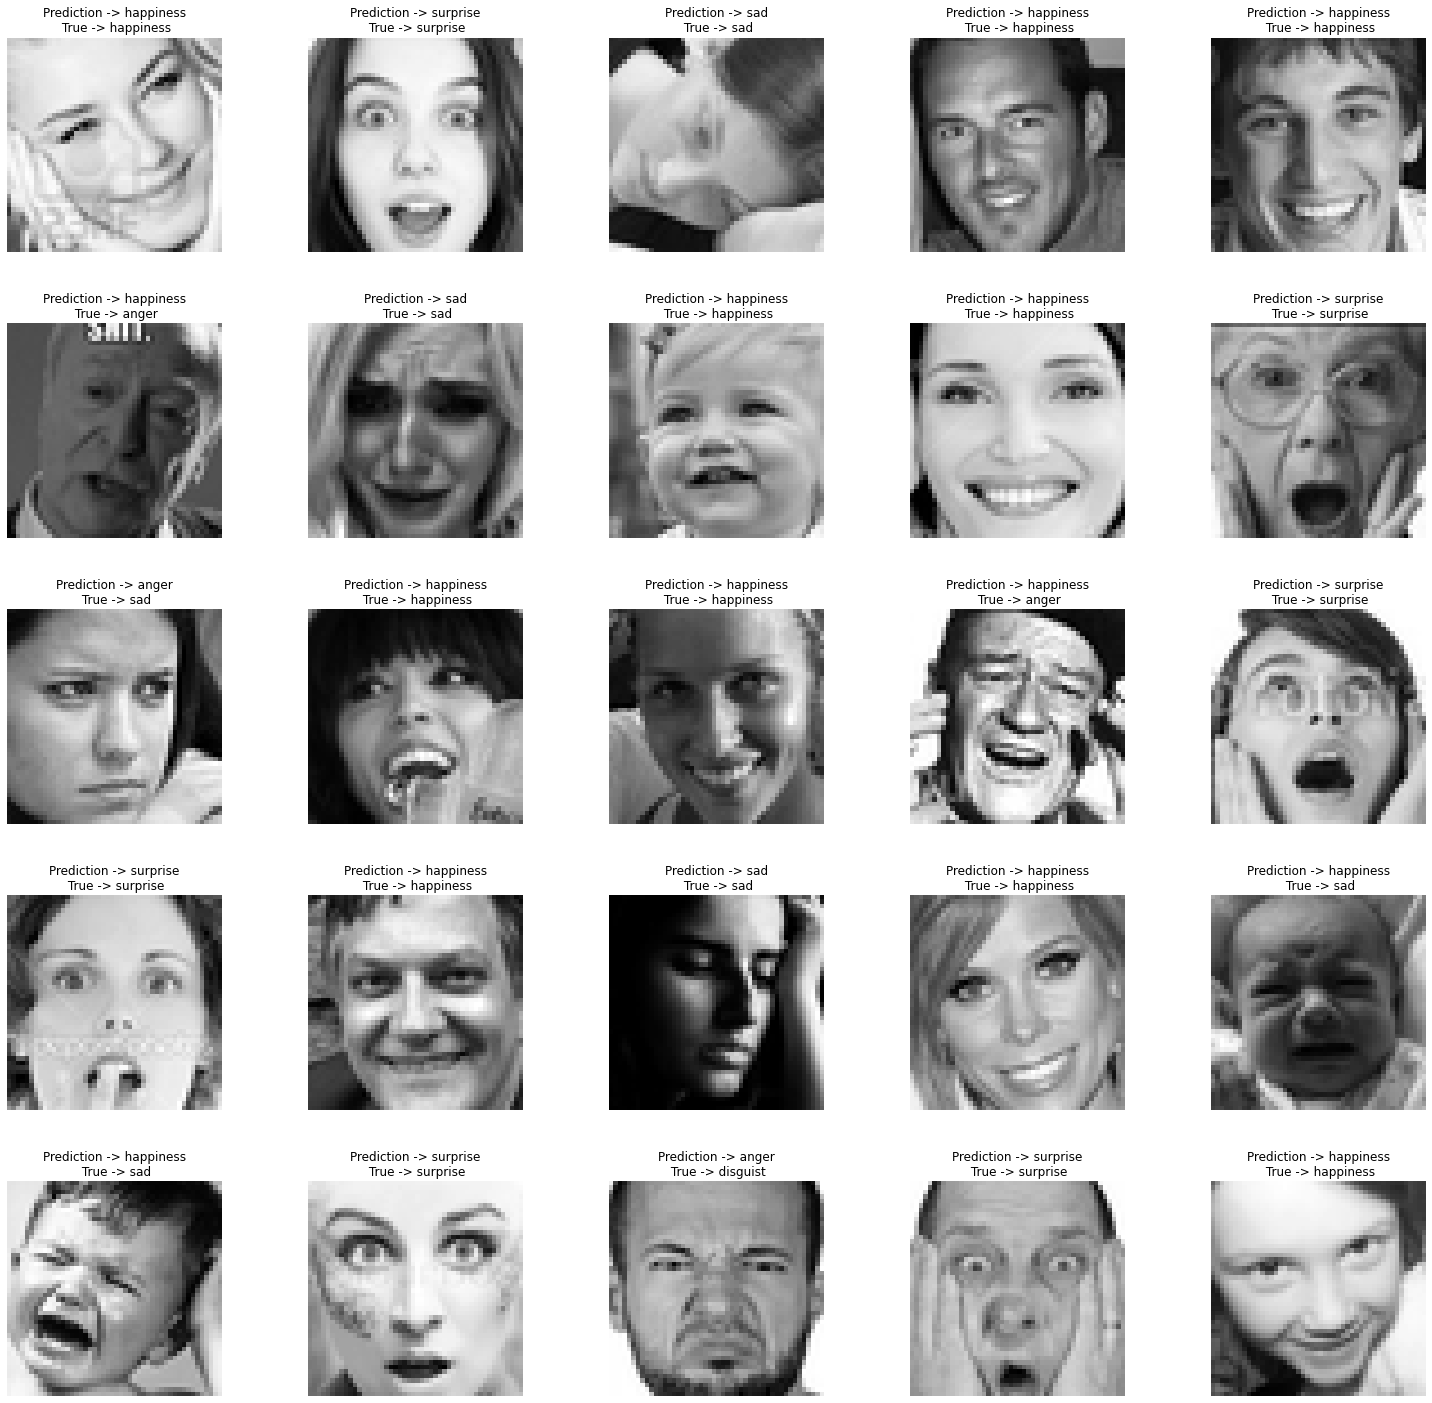

In [56]:
# Plot 25 images with Predicted and True Labels

L,W = 5,5 # Length and Width for Images

fig, ax= plt.subplots(L,W, figsize= (20,20))
ax = ax.ravel()

for i in np.arange(0, L*W):
    ax[i].imshow(X_test[i].squeeze(), cmap= "gray") # You can use .reshape(48,48) instead of squeeze()
    ax[i].set_title("Prediction -> {}\n True -> {}".format(label_to_text[prediction[i]],label_to_text[y_true[i]]))
    ax[i].axis("off")

plt.tight_layout()

# Adjust the Width between each plots
plt.subplots_adjust(wspace= 0.4)
plt.show();